# Full code pipeline for running an ensemble on the provided ECG data with PySpark and Torch
Note: You need to run the Docker Image to get the appropraite dependencies correct to run this notebook yourself. See our [docker.md](docker.md) for instructions.

## Start spark session
This will be used by `TorchDistributor` to allocate the necessary memory space for each process.

In [1]:
from pyspark.ml.torch.distributor import TorchDistributor 
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

## Install torch
This is the only package we need that isn't part of the Docker Image that you need to use to run this code.

In [2]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 MB 6.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 4.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
Note: you may need to restart the kernel to use updated packages.


## Import libraries and create directory for models
Most important package is torch, some of the packages are only used for visualizations or to manage the data. Importantely we also import functions from the [utils.py](utils.py) file in the repository, this is done further down for pedagogical reasons.

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, DataLoader
from scipy import stats
import time as time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings
from datetime import datetime

# We create a new directory called 'models_and_results/CURRENT_DATE_TIME' where we store 
# the models and the corresponding anomaly scores
warnings.filterwarnings("ignore", category=FutureWarning)
current_time = datetime.now().strftime('%d%m_%H%M%S')
base_directory = './models_and_results/'
new_directory = os.path.join(base_directory, current_time)
os.makedirs(new_directory, exist_ok=True)

## Import the dataset

The dataset has been taken from [this link](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). It comprises 4998 stime series, each evaluated in 140 time points. An additional column is added for labels (1: normal, 0: anomalous) There are 2079 normal signals in total (41.6% of the total dataset).
* `input_dim`: number of time points for each time series.
* `encoding_dim`: number of encoded features in the latent space.

The following code imports and prepares the dataset for training and testing.

In [4]:
# For reproducibility we set a seed. 
random_SEED = 42
np.random.seed(random_SEED) 

# Load data
df_raw_data = pd.read_csv('ECG5000/ecg.csv', header=None) 
# Set name for columns
df_raw_data.columns = [f't{i+1}' for i in range(df_raw_data.shape[1] - 1)] + ['label'] 
# Transform to tensor (last column is for label)
torch_data_normal = torch.tensor(df_raw_data[df_raw_data['label'] == True].values[:,:-1], dtype=torch.float32) 
# Transform to tensor (last column is for label)
torch_data_anomalous = torch.tensor(df_raw_data[df_raw_data['label'] == False].values[:,:-1], dtype=torch.float32) 

# We hold out some normal data that later is used for testing, 
# the rest of the normal data we store in torch_data_normal
hold_out_idx = torch.tensor(random.sample(range(torch_data_normal.shape[0]), 500)) 
all_indices = torch.arange(torch_data_normal.shape[0]) 
remaining_indices = all_indices[~torch.isin(all_indices, hold_out_idx)]
hold_out_normal = torch_data_normal[hold_out_idx,:]
torch_data_normal = torch_data_normal[remaining_indices,:]

# The following variables are used when defining our Autoencoder model
input_dim = torch_data_normal.shape[1]
encoding_dim = 10

## Print some numbers of the data
print(f'Training data (normal): {torch_data_normal.shape[0]}')
print(f'Anomalous data: {torch_data_anomalous.shape[0]}')
print(f'Hold-out data (normal): {hold_out_normal.shape[0]}')
print(f'Total data: {hold_out_normal.shape[0]+torch_data_anomalous.shape[0]+torch_data_normal.shape[0]}')

Training data (normal): 2419
Anomalous data: 2079
Hold-out data (normal): 500
Total data: 4998


## Split the dataset inot `num_splits` chunks
* `num_splits`:  number of chunks to partition the dataset into.
* This will also be the same number of nodes (CPU cores) we distribute to.

In [5]:
train_datasets = []

# Chose arbitrary number of splits (less than 10 for data of this size)
num_splits = 9
# Make as even splits as possible
split_sizes = [torch_data_normal.shape[0] // num_splits] * (num_splits - 1) + [torch_data_normal.shape[0] - (torch_data_normal.shape[0] // num_splits) * (num_splits - 1)]
train_datasets = torch.split(torch_data_normal, split_sizes)
for tt_idx, tt in enumerate(train_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

268 data in chunk number 1
268 data in chunk number 2
268 data in chunk number 3
268 data in chunk number 4
268 data in chunk number 5
268 data in chunk number 6
268 data in chunk number 7
268 data in chunk number 8
275 data in chunk number 9


## Define the model 
The same model will be used by each process, by this could be generalized 
Here we define an Autoencoder with an encoder three linear layers and ReLU activation between the the layers. The Decoder consists of a mirrored architecture.

In [6]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded
    
# We create a list containing the models
models = [] 
# We initialize a model for each node (CPU core) 
for i in range(num_splits): 
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))

## Import training functions
From [utils.py](utils.py) we import the functions train_data_loader and training, where the second function will be distributed by TorchDistributor. See [utils.py](utils.py) for detailed comments on these functions.

In [7]:
from utils import train_data_loader, training

## Run the training function with TorchDistributor
In [report.md](report.md) you can see the general structure of this function that distributes the training function among the nodes (CPU cores with the current setting). 

In [8]:
# Define a loss function
criterion = nn.MSELoss()

# Hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.01

# Print the loss function's value every print_epoch epochs
print_epoch = 100

# Benchmark the training
start_time = time.time()

# Run takes arguments: (<function to be run>, <arguments to be passed to function>)
TorchDistributor(num_processes=num_splits, 
                    local_mode=True, 
                    use_gpu=False
                ).run(training,                                            # Function to distribute
                models, train_datasets, criterion, num_epochs,             # Arguments to pass to function
                batch_size, learning_rate, print_epoch, new_directory)     # Arguments to pass to function

print('Training took ' , time.time()-start_time ,'s')

Started local training with 9 processes
Finished local training with 9 processes


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
Model 5 Epoch [100/100], Loss: 0.030189
Model 3 Epoch [100/100], Loss: 0.026124
Model 0 Epoch [100/100], Loss: 0.032603
Model 8 Epoch [100/100], Loss: 0.030304
Model 7 Epoch [100/100], Loss: 0.022068
Model 6 Epoch [100/100], Loss: 0.028629
Model 2 Epoch [100/100], Loss: 0.023486
Model 4 Epoch [100/100], Loss: 0.024753
Model 1 Epoch [100/100], Loss: 0.024837
Training took  13.680084466934204 s


# Inference 
Now the training is finished and we move on to the inference stage of this pipeline.

## Load models from directory

In [9]:
# We load the models by creating a new list, initialzing each model and loading the corresponding weights
models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))
    models[i].load_state_dict(torch.load(new_directory + os.sep + "ensemble_" + str(i) + ".pth", weights_only=True))
    models[i].eval()

## Prepare test data
We do the inference over an even split of normal and anamlous time series. This results in that the first 500 data series in `new_patients` are normal signals, and the last 500 are anomalies. 

The new data are then partitioned across `num_splits` processes. This split is not required for this particular data (due to the small size) but is used to show that if the test dataset is larger than one machine can handle, our partition makes it feasible by letting each machine loop over one chunk of the partition at a time.

In [10]:
# Concatenate the 500 normal test data with 500 randomly sampled anomalous time series.
new_patients = torch.concat((hold_out_normal, torch_data_anomalous[torch.tensor(random.sample(range(torch_data_anomalous.shape[0]), 500)),:]))

# Create corresponding labels for the 500 normals (ones) and 500 anomalous (zeros)
true_labels = torch.concat((torch.ones(500), torch.zeros(500))).numpy() 

# Partition the data into the list test_datasets
test_datasets = []
num_splits = 9
split_sizes = [new_patients.shape[0] // num_splits] * (num_splits - 1) + [new_patients.shape[0] - (new_patients.shape[0] // num_splits) * (num_splits - 1)]
test_datasets = torch.split(new_patients, split_sizes)
for tt_idx, tt in enumerate(test_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

111 data in chunk number 1
111 data in chunk number 2
111 data in chunk number 3
111 data in chunk number 4
111 data in chunk number 5
111 data in chunk number 6
111 data in chunk number 7
111 data in chunk number 8
112 data in chunk number 9


## Inference function to be called by TorchDistributor
This function `inference` is a distributed function that computes the ECDF on the current node's training data. In particular, `normal_ecdf`, defined below, is the estimated ECDF, see the [report.md](report.md). The function then proceeds to evaluate the anomaly scores over the whole partitioned data set. This function is defined in [utils.py](utils.py) where you can see detailed comments on its functionality.

In [11]:
from utils import inference

Call TorchDistributor on the inference function, to distribute the work among `num_splits` nodes, see [report.md](report.md) for details and references how to use TorchDistributor.

In [12]:
# Benchmark the time
start_time = time.time()

TorchDistributor(num_processes=num_splits, 
                    local_mode=True, 
                    use_gpu=False
                ).run(inference,                         # Function to distribute
                models, test_datasets, train_datasets,   # Arguments to pass to function
                num_splits, nn.MSELoss(), new_directory) # Arguments to pass to function
    
print('It took ' , time.time()-start_time ,'s')


Started local training with 9 processes
Finished local training with 9 processes


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
It took  7.96666145324707 s


## Load results

In [13]:
# Store all results (anomaly scores) in the list 'np_result_all' 
np_result_all = []

# Load all results (anomaly scores) from directory
for i in range(num_splits):
    if i == 0:
        np_result_all = np.load(new_directory + os.sep + "inference_" + str(i) + ".npy")
    else:
        np_result_all = np.vstack([np_result_all, np.load(new_directory + os.sep + "inference_" + str(i) + ".npy")])

# Convert to the list to a numpy matrix
np_result_all = np.array(np_result_all)

# Make a list where each element is a column from the np_result_all matrix
result_all = [np_result_all[:, i] for i in range(np_result_all.shape[1])]


## Plot the anomaly scores for test data
The y-axis of these plots represent the anomaly scores, which are in [0, 1] by construction (the anomaly score is a probability)

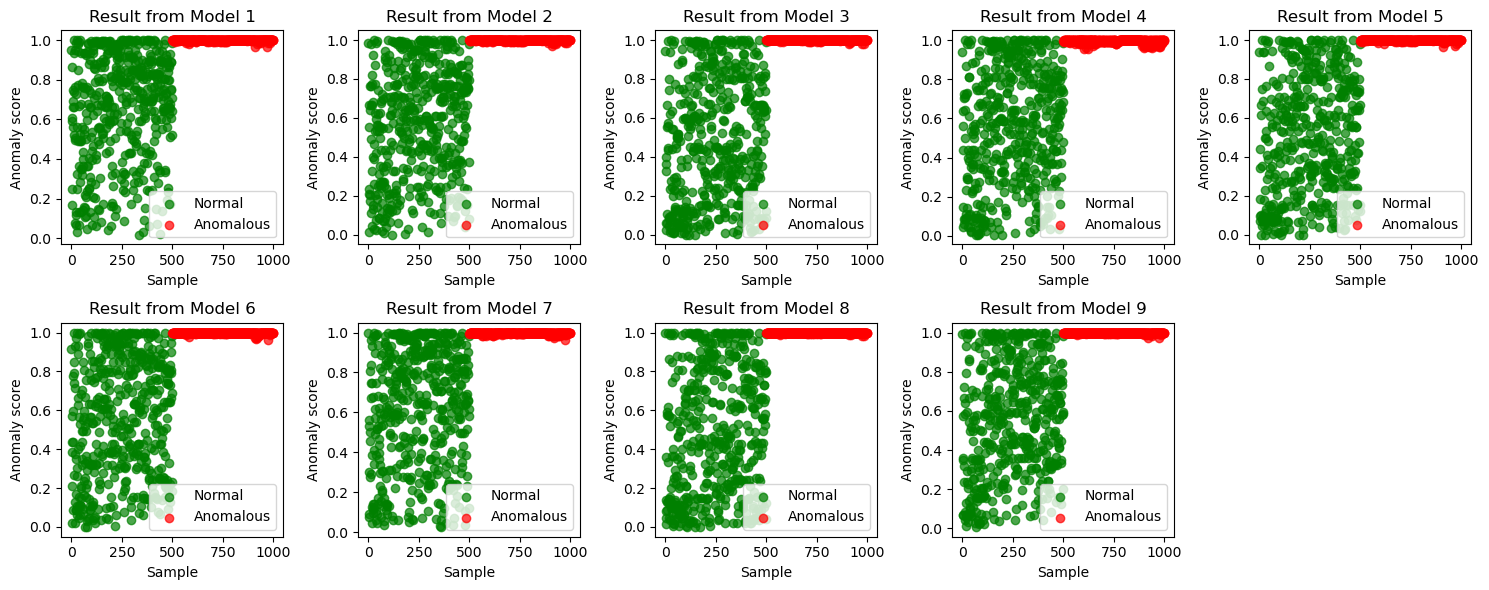

In [14]:
# Maximal number of columns in plot
max_cols = 5
# Maximal number of rows in plot
max_rows = int(np.ceil(num_splits / 5))  # for plotting purposes

# Plot figures
plt.figure(figsize=(15, max_rows * 3)) 
for i in range(num_splits):
    plt.subplot(max_rows, max_cols, i + 1) 
    
    # Separate points for 'Normal' and 'Anomalous'
    normal_indices = [idx for idx, label in enumerate(true_labels) if label == 1]
    anomalous_indices = [idx for idx, label in enumerate(true_labels) if label == 0]
    
    # Plot 'Normal' (green) points
    plt.scatter(normal_indices, [result_all[i][j] for j in normal_indices], color='green', label='Normal',alpha=0.7)
    # Plot 'Anomalous' (red) points
    plt.scatter(anomalous_indices, [result_all[i][j] for j in anomalous_indices], color='red', label='Anomalous',alpha=0.7)
    
    # Titles and labels
    plt.title(f"Result from Model {i+1}")
    plt.ylabel('Anomaly score')
    plt.xlabel('Sample')
    
    # Add legend
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


## Set threshold, evaluate performance of the ensemble

We use confusion matrices to measure the performance of our anomaly detection method. In this context, the anomalous ECGs are the positive class (1), and the normal EGSs are the negative class (0).

- True Positive (TP): A sample correctly classified as anomalous.
- False Positive (FP): A sample incorrectly classified as anomalous.
- False Negative (FN): A sample incorrectly classified as normal.
- True Negative (TN): A sample correctly classified as normal.

Moreover, we calculate the accuracy, precision, and recall to evaluate the performance of the model:
 
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$


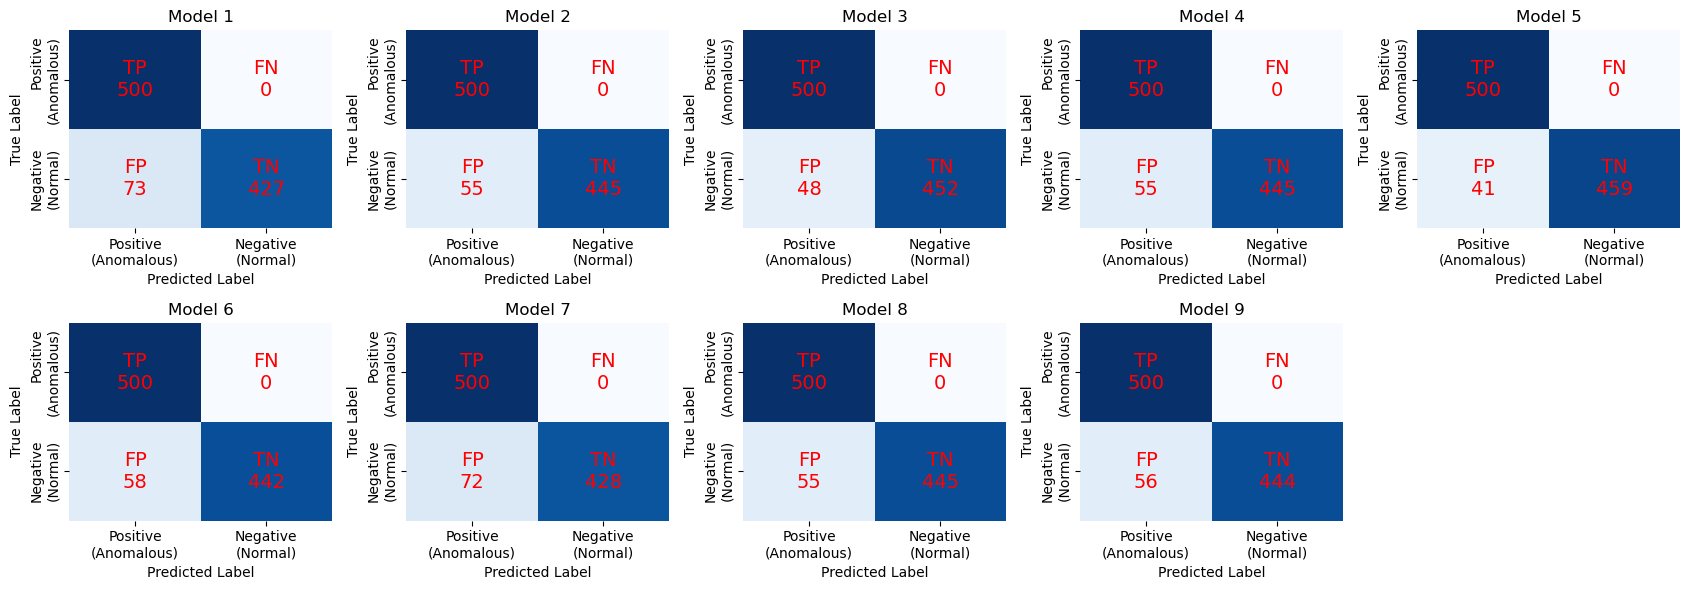

In [15]:
# Threshold for anomaly detection
# Anomaly scores greater than 1-alpha are labeled as anomalous
alpha = 0.05

# Initialize
selected_indices_all = []
predicted_labels_all = []
cm_all = []
accuracy_all = []
precision_all = []
recall_all = []

# Calculate confusion matrices and metrics
for i in range(num_splits):
    
    # Load results for model i
    result_i = result_all[i]

    # Label as anomalous if exceeding threshold 
    selected_indices_i = np.where(result_i > 1 - alpha)
    selected_indices_all.append(selected_indices_i)
    selected_values_i = result_i[selected_indices_i]

    # Positive = 1 = Anomaly
    # Negative = 0 = Normal
    predicted_labels_i = np.zeros_like(true_labels)
    predicted_labels_i[selected_indices_i] = 1
    predicted_labels_all.append(predicted_labels_i)

    # Invert the true labels to match predicted labels
    cm_i = confusion_matrix(1-true_labels, predicted_labels_i, labels=[1, 0])
    cm_all.append(cm_i)

    # Calculate accuracy, precision and recall
    accuracy_i = accuracy_score(1-true_labels, predicted_labels_i)
    accuracy_all.append(accuracy_i)
    precision_i = precision_score(1-true_labels, predicted_labels_i)
    precision_all.append(precision_i)
    recall_i = recall_score(1-true_labels, predicted_labels_i)
    recall_all.append(recall_i)

# Plot confusion matrices
plt.figure(figsize=(17, (num_splits + 4) // 5 * 3))  # Adjust figure size based on number of splits
for i in range(num_splits):
    plt.subplot((num_splits + 4) // 5, 5, i + 1)
    ax = sns.heatmap(cm_all[i], annot=False, fmt="d", cmap="Blues", cbar=False,
                     xticklabels=['Positive\n(Anomalous)', 'Negative\n(Normal)'], 
                     yticklabels=['Positive\n(Anomalous)', 'Negative\n(Normal)'])
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.title(f"Model {i+1}")

    # Add TP, TN, FP, FN labels
    cm = cm_all[i]
    # Confusion matrix is 2x2
    for row in range(2):  
        for col in range(2):
            value = cm[row, col]
            if row == 0 and col == 0:
                # True Positive
                text = "TP"  
            elif row == 0 and col == 1:
                # False Negative
                text = "FN"  
            elif row == 1 and col == 0:
                # False Positive
                text = "FP"  
            else:
                # True Negative
                text = "TN"  
            ax.text(col + 0.5, row + 0.5, f"{text}\n{value}",
                    ha="center", va="center", color="red", fontsize=14)

plt.tight_layout()
plt.show()


Print the accuracy, precision and recall for all models.

In [16]:
# Collect results in a list of dictionaries
results = []
for i in range(num_splits):
    results.append({
        'Model': f'Model {i+1}',
        'Accuracy': accuracy_all[i],
        'Precision': precision_all[i],
        'Recall': recall_all[i]
    })

# Convert to DataFrame for a nice table
df_results = pd.DataFrame(results)
print(df_results)


     Model  Accuracy  Precision  Recall
0  Model 1     0.927   0.872600     1.0
1  Model 2     0.945   0.900901     1.0
2  Model 3     0.952   0.912409     1.0
3  Model 4     0.945   0.900901     1.0
4  Model 5     0.959   0.924214     1.0
5  Model 6     0.942   0.896057     1.0
6  Model 7     0.928   0.874126     1.0
7  Model 8     0.945   0.900901     1.0
8  Model 9     0.944   0.899281     1.0


## Merge results
The anomaly score of the ensemble is the sample average of the anomaly scores of the models.

In [17]:
# Create the merged result
result_merged = np.array([sum(x)/num_splits for x in zip(*result_all)])

Plot the anomaly scores for the merged model.

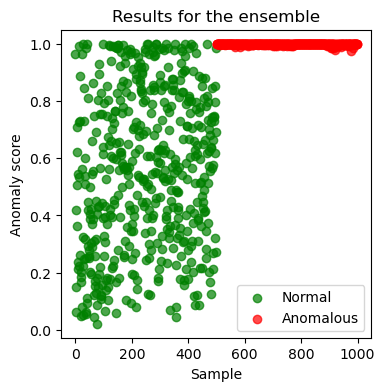

In [18]:
# Plot the anomaly scores for the ensemble
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)  

# Separate points for 'Normal' and 'Anomalous'
normal_indices = [idx for idx, label in enumerate(true_labels) if label == 1]
anomalous_indices = [idx for idx, label in enumerate(true_labels) if label == 0]

# Plot 'Normal' (green) points
plt.scatter(normal_indices, [result_merged[j] for j in normal_indices], color='green', label='Normal',alpha=0.7)
# Plot 'Anomalous' (red) points
plt.scatter(anomalous_indices, [result_merged[j] for j in anomalous_indices], color='red', label='Anomalous',alpha=0.7)

# Titles and labels
plt.title(f"Results for the ensemble")
plt.ylabel('Anomaly score')
plt.xlabel('Sample')

# Add legend
plt.legend(loc='lower right')

Plot the confusion matrix for the merged model.

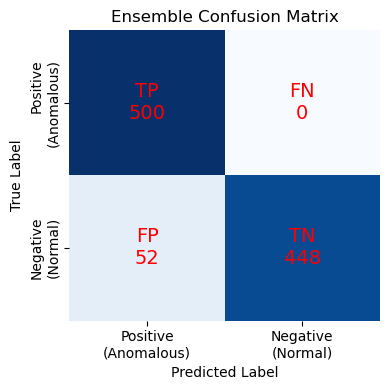

Accuracy for the ensemble: 0.948
Precision for the ensemble: 0.9057971014492754
Recall for the ensemble: 1.0


In [19]:
# Select anomalous points based on the threshold
selected_indices_merged = np.where(result_merged > 1 - alpha)
selected_values_merged = result_merged[selected_indices_merged]

# Predicted labels for the merged result
predicted_labels_merged = np.zeros_like(true_labels)
predicted_labels_merged[selected_indices_merged] = 1

# Generate confusion matrix for the ensemble
cm_merged = confusion_matrix(1-true_labels, predicted_labels_merged, labels=[1,0])

# Calculate accuracy, precision, and recall
accuracy_merged = accuracy_score(1-true_labels, predicted_labels_merged)
precision_merged = precision_score(1-true_labels, predicted_labels_merged)
recall_merged = recall_score(1-true_labels, predicted_labels_merged)

# Plot the confusion matrix for the ensemble
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)  

# Plot the heatmap of the confusion matrix
ax = sns.heatmap(cm_merged, annot=False, fmt="d", cmap="Blues", cbar=False,
                 xticklabels=['Positive\n(Anomalous)', 'Negative\n(Normal)'], 
                 yticklabels=['Positive\n(Anomalous)', 'Negative\n(Normal)'])

# Add TP, TN, FP, FN labels
# Confusion matrix is 2x2
for row in range(2):  
    for col in range(2):
        value = cm_merged[row, col]
        if row == 0 and col == 0:
            # True Positive
            text = "TP"  
        elif row == 0 and col == 1:
            # False Negative
            text = "FN"  
        elif row == 1 and col == 0:
            # False Positive
            text = "FP"  
        else:
            # True Negative
            text = "TN"  
        ax.text(col + 0.5, row + 0.5, f"{text}\n{value}",
                ha="center", va="center", color="red", fontsize=14)

# Titles and labels
plt.title(f"Ensemble Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

# Print
print(f"Accuracy for the ensemble: {accuracy_merged}")
print(f"Precision for the ensemble: {precision_merged}")
print(f"Recall for the ensemble: {recall_merged}")